<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/BA_image%2Blabels_workingPICAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports + Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
import pandas as pd
import numpy as np
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os

# Loading in train images+labels & test images

In [21]:
labels_file_path = '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv'
labels_df = pd.read_csv(labels_file_path)

image_folder_path = '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data'
image_file_paths = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path)]

In [22]:
image_file_paths

['/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/9424.png',
 '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/9398.png',
 '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/9422.png',
 '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/944.png',
 '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/9267.png',
 '/content/gdrive/MyDrive/0. MSc MLiS/google SPRING SEMESTER/1. PHYS4036 MLiS2/MLiS2 Project/KAGGLEDATAmachine-

In [23]:
target_size = (227, 227) # target image size

In [24]:
# Manually load and preprocess images
def load_and_preprocess_image(image_path, target_size):
    try:
        # Read and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)  # Resize images to a common size
        image = image / 255.0  # Normalize pixel values to the range [0, 1]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}. Skipping this example.")
        return None

In [25]:
# Create a dataset generator
def image_data_generator(image_ids, features_df, image_folder_path, target_size):
    for image_id in image_ids:
        image_path = f'{image_folder_path}/{image_id}.png'
        image = load_and_preprocess_image(image_path, target_size)
        if image is not None:
            features = features_df[features_df['image_id'] == image_id]
            if not features.empty:
                angle = features['angle'].values[0]
                speed = features['speed'].values[0]
                yield image, [angle, speed]


# Train, val, test split

In [26]:
# Split data into training (70%), validation (20%), and test (10%) sets
train_ids, test_ids = train_test_split(labels_df['image_id'], test_size=0.1, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2222, random_state=42)  # 0.2222 * 90% = 20%

In [30]:
# Create tf.data.Datasets
batch_size = 5

train_dataset = tf.data.Dataset.from_generator(
    lambda: image_data_generator(train_ids, labels_df, image_folder_path, target_size),
    output_types=(tf.float32, tf.float32),
    output_shapes=((227, 227, 3), (2,))
).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: image_data_generator(val_ids, labels_df, image_folder_path, target_size),
    output_types=(tf.float32, tf.float32),
    output_shapes=((227, 227, 3), (2,))
).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: image_data_generator(test_ids, labels_df, image_folder_path, target_size),
    output_types=(tf.float32, tf.float32),
    output_shapes=((227, 227, 3), (2,))
).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [32]:
# Get one batch from the dataset
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Image data type:", images.dtype)
    print("Labels data type:", labels.dtype)
    print("Sample image range:", tf.reduce_min(images[0]), "to", tf.reduce_max(images[0]))
    print("Sample label:", labels[0])

Batch shape: (5, 227, 227, 3)
Labels shape: (5, 2)
Image data type: <dtype: 'float32'>
Labels data type: <dtype: 'float32'>
Sample image range: tf.Tensor(0.0, shape=(), dtype=float32) to tf.Tensor(1.0, shape=(), dtype=float32)
Sample label: tf.Tensor([0.875 1.   ], shape=(2,), dtype=float32)


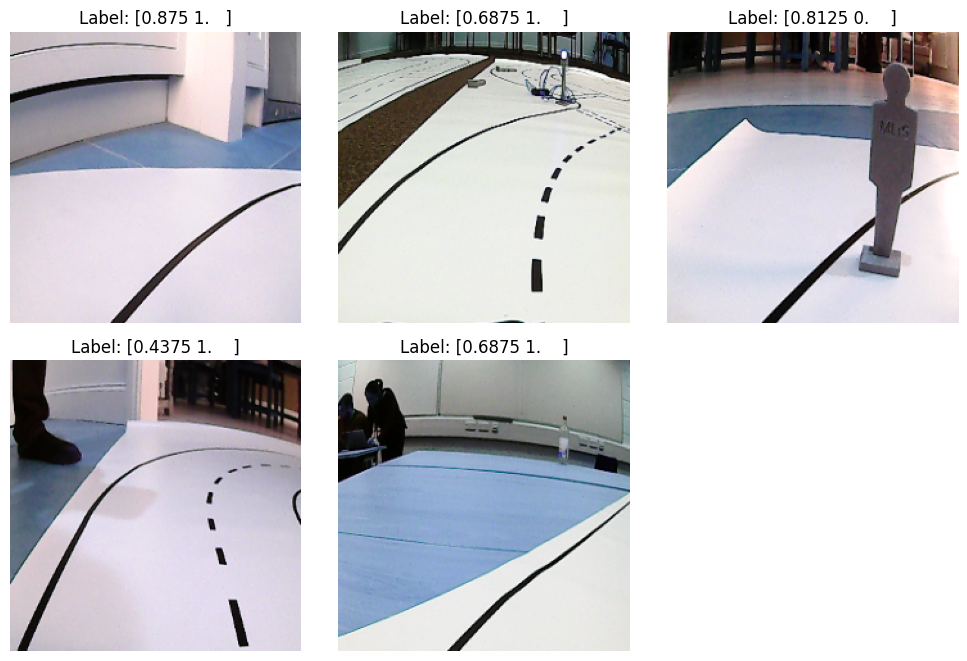

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
plt.tight_layout()
plt.show()